## Ensemble voting

In [173]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from keras.models import model_from_json
from keras.metrics import categorical_accuracy

import keras
import random

%matplotlib inline

### Helper functions

In [174]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

In [175]:
def load_data(dataset: str, channels: int = 1):
  
    df = pd.read_csv(dataset)
  
    df['category'] = df['category'].str.strip()

    train = df.loc[df.category == 'Training',:]
    valid = df.loc[df.category == 'PublicTest',:]
    test  = df.loc[df.category == 'PrivateTest',:]

    del train['Unnamed: 0']
    del valid['Unnamed: 0']
    del test['Unnamed: 0']

    X_train = np.array(train.iloc[:, 1:2305])
    y_train = np.array(train.loc[:, ['y']])

    X_val = np.array(valid.iloc[:, 1:2305])
    y_val = np.array(valid.loc[:, ['y']])

    X_test = np.array(test.iloc[:, 1:2305])
    y_test = np.array(test.loc[:, ['y']])

    del train
    del valid
    del test

    y_train = keras.utils.to_categorical(y_train, 7)
    y_val = keras.utils.to_categorical(y_val, 7)
    y_test = keras.utils.to_categorical(y_test, 7)

    X_train_r = X_train.reshape((len(X_train), 48, 48))
    X_val_r   = X_val.reshape((len(X_val), 48, 48))
    X_test_r   = X_test.reshape((len(X_test), 48, 48))

    X_train_r = X_train_r / 255
    X_val_r = X_val_r / 255
    X_test_r = X_test_r / 255

    if channels == 1:
        X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
        X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
        X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))
        return (X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test)
    elif channels == 3:
        X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
        X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
        X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)
        return (X_train_rgb, X_val_rgb, X_test_rgb, y_train, y_val, y_test)
    else:
        return None

In [176]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [177]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [178]:
def argmax(row, accuracies):
    
    vals = {}
    
    for i in row:
        if i in vals:
            vals[i] = vals[i] + 1
        else:
            vals[i] = 1
    
    classes = []
    
    if list(vals.values()).count(2) == 2:
        
        for key, val in vals.items():
            if val == 2:
                classes.append(key)
        
        voters = {
            classes[0]: [],
            classes[1]: []
        }
            
        for clazz in classes:
            for index, vote in enumerate(row):
                if vote == clazz:
                    voters[clazz].append(accuracies[index])
        
        if sum(voters[classes[0]]) > sum(voters[classes[1]]):
            return classes[0]
        else:
            return classes[1]
    else:
        return stats.mode(row)[0][0]

### Read data from disk

In [179]:
X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test = load_data('../data/emotions/emotions.csv')

### Read models from disk

In [180]:
baseline = read_model_from_disk(model='../models/baseline.json', 
                                weights='../models/weights/baseline.h5')

In [181]:
aug_base = read_model_from_disk(model='../models/augmented-baseline.json', 
                                weights='../models/weights/augmented-baseline.h5')

In [182]:
alexnet = read_model_from_disk(model='../models/augmented-alexnet.json',
                               weights='../models/weights/alexnet.h5')

In [183]:
aug_alex = read_model_from_disk(model='../models/augmented-alexnet.json',
                             weights='../models/weights/augmented-alexnet.h5')

In [184]:
vgg = read_model_from_disk(model='../models/vgg.json',
                          weights='../models/weights/vgg.h5')

In [185]:
vgg_org = read_model_from_disk(model='../models/vgg19-other.json',
                              weights='../models/weights/vgg19-other.h5')

## Validation set accuracy

### Calculate model performance separately

#### Baseline model

In [186]:
baseline.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 39s 11ms/step


[2.123457921069457, 0.6361103371578726]

#### Baseline model with data augmentation

In [187]:
aug_base.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 36s 10ms/step


[1.1671931215666502, 0.65477848983834]

#### AlexNet model

In [188]:
alexnet.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 33s 9ms/step


[1.9576191461063022, 0.6157704096180577]

#### AlexNet model with augmentation

In [189]:
aug_alex.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 33s 9ms/step


[1.2867695243121455, 0.635274449724047]

#### VGG-19 model

In [190]:
vgg.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 19s 5ms/step


[1.1080714116756814, 0.6458623572108672]

#### Original VGG-19 model

In [191]:
vgg_org.evaluate(X_val_bw, y_val, verbose=1)

3589/3589 [==============================] - 105s 29ms/step


[1.0205228924585206, 0.6620228476230731]

### Ensemble of 3 strongest models

In [192]:
models = [aug_base, vgg, vgg_org]

labels = []

for m in models:
    labels.append(m.predict_classes(X_val_bw))
    
labels = np.array(labels).transpose()

results = pd.DataFrame(labels, columns=['AugBase', 'VGG', 'VGGOriginal'])

results['True'] = np.argmax(y_val, axis = 1)

for col in results.columns:
    results[col] = results[col].map(mapping)

In [193]:
pred = stats.mode(labels, axis= -1)[0]

y = pd.DataFrame(np.argmax(y_val, axis = 1), columns=['true'])

y['pred'] = pred

####  `validatoin set` accuracy using ensemble of 3 models

In [194]:
sum(y['pred'] == y['true']) / len(y)

0.6681526887712455

### Ensemble of 5 strongest models

In [195]:
models = [baseline, aug_base, aug_alex, vgg, vgg_org]

labels = []

for m in models:
    labels.append(m.predict_classes(X_val_bw))
    
labels = np.array(labels).transpose()

results = pd.DataFrame(labels, columns=['Baseline', 'AugBase', 'AugAlex', 'VGG', 'VggOrig'])

results['True'] = np.argmax(y_val, axis = 1)

for col in results.columns:
    results[col] = results[col].map(mapping)
    
results.head()

,Baseline,AugBase,AugAlex,VGG,VggOrig,True
0,Neutral,Disgust,Neutral,Angry,Neutral,Angry
1,Disgust,Disgust,Disgust,Disgust,Disgust,Disgust
2,Angry,Angry,Angry,Angry,Angry,Sad
3,Fear,Fear,Fear,Sad,Fear,Neutral
4,Happy,Happy,Happy,Happy,Happy,Happy


#### Argmax voting 

In [196]:
pred = stats.mode(labels, axis= -1)[0]

y = pd.DataFrame(np.argmax(y_val, axis = 1), columns=['true'])

y['pred'] = pred

####  `validatoin set` accuracy using ensemble of 5 models and argmax voting

In [197]:
sum(y['pred'] == y['true']) / len(y)

0.6773474505433268

#### Smart voting

In [198]:
# accuracies = {
#     0: 0.64224017,
#     1: 0.67205349,
#     2: 0.64307606,
#     3: 0.67038172,
#     4: 0.67539704,
# }

accuracies = {
    0: 0.6361103371578726,
    1: 0.65477848983834,
    2: 0.635274449724047,
    3: 0.6458623572108672,
    4: 0.6620228476230731,
}

In [199]:
smart_pred = []

for row in labels:
    smart_pred.append(argmax(row, accuracies))
    
y = pd.DataFrame(np.argmax(y_val, axis = 1), columns=['true'])

y['pred'] = smart_pred

####  `validatoin set` accuracy using ensemble of 5 models and smart voting

In [200]:
sum(y['pred'] == y['true']) / len(y)

0.6809696294232377

## `Test` set accuracy

### Ensemble of 3 strongest models

In [201]:
models = [aug_base, vgg, vgg_org]

labels = []

for m in models:
    labels.append(m.predict_classes(X_test_bw))
    
labels = np.array(labels).transpose()

results = pd.DataFrame(labels, columns=['AugBase', 'VGG', 'VGGOriginal'])

results['True'] = np.argmax(y_test, axis = 1)

for col in results.columns:
    results[col] = results[col].map(mapping)

In [202]:
pred = stats.mode(labels, axis= -1)[0]

y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

y['pred'] = pred

####  `test set` accuracy using ensemble of 3 strongest models 

In [203]:
sum(y['pred'] == y['true']) / len(y)

0.6935079409306213

### Ensemble of 5 strongest models

In [204]:
models = [baseline, aug_base, aug_alex, vgg, vgg_org]

labels = []

for m in models:
    labels.append(m.predict_classes(X_test_bw))
    
labels = np.array(labels).transpose()

results = pd.DataFrame(labels, columns=['Baseline', 'AugBase', 'AugAlex', 'VGG', 'VggOrig'])

results['True'] = np.argmax(y_test, axis = 1)

for col in results.columns:
    results[col] = results[col].map(mapping)
    
results.head()

,Baseline,AugBase,AugAlex,VGG,VggOrig,True
0,Angry,Angry,Angry,Neutral,Angry,Angry
1,Angry,Angry,Fear,Angry,Fear,Surprise
2,Fear,Fear,Fear,Fear,Fear,Neutral
3,Sad,Sad,Angry,Angry,Sad,Sad
4,Angry,Angry,Surprise,Sad,Fear,Fear


#### Argmax voting

In [205]:
pred = stats.mode(labels, axis= -1)[0]

y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

y['pred'] = pred

####  `test set` accuracy using ensemble of 5 models and argmax voting

In [206]:
sum(y['pred'] == y['true']) / len(y)

0.6990805238227918

#### Smart voting

In [207]:
# accuracies = {
#     0: 0.64224017,
#     1: 0.67205349,
#     2: 0.64307606,
#     3: 0.67038172,
#     4: 0.67539704,
# }

accuracies = {
    0: 0.6361103371578726,
    1: 0.65477848983834,
    2: 0.635274449724047,
    3: 0.6458623572108672,
    4: 0.6620228476230731,
}

In [208]:
smart_pred = []

for row in labels:
    smart_pred.append(argmax(row, accuracies))
    
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

y['pred'] = smart_pred

####  `test set` accuracy using ensemble of 5 models and smart voting

In [209]:
sum(y['pred'] == y['true']) / len(y)

0.7032599609919198

### Visualize erroneous predictions (Ensemble of 5 models with smart voting)

In [210]:
y['true'] = y['true'].map(mapping)
y['pred'] = y['pred'].map(mapping)

misclassified = y[(y['true'] != y['pred'])]

indices = misclassified.index.values

misclassified = misclassified.reset_index()

indices = list(indices)

images = X_test_bw[indices, ]

### `true` $\rightarrow$ `predicted`

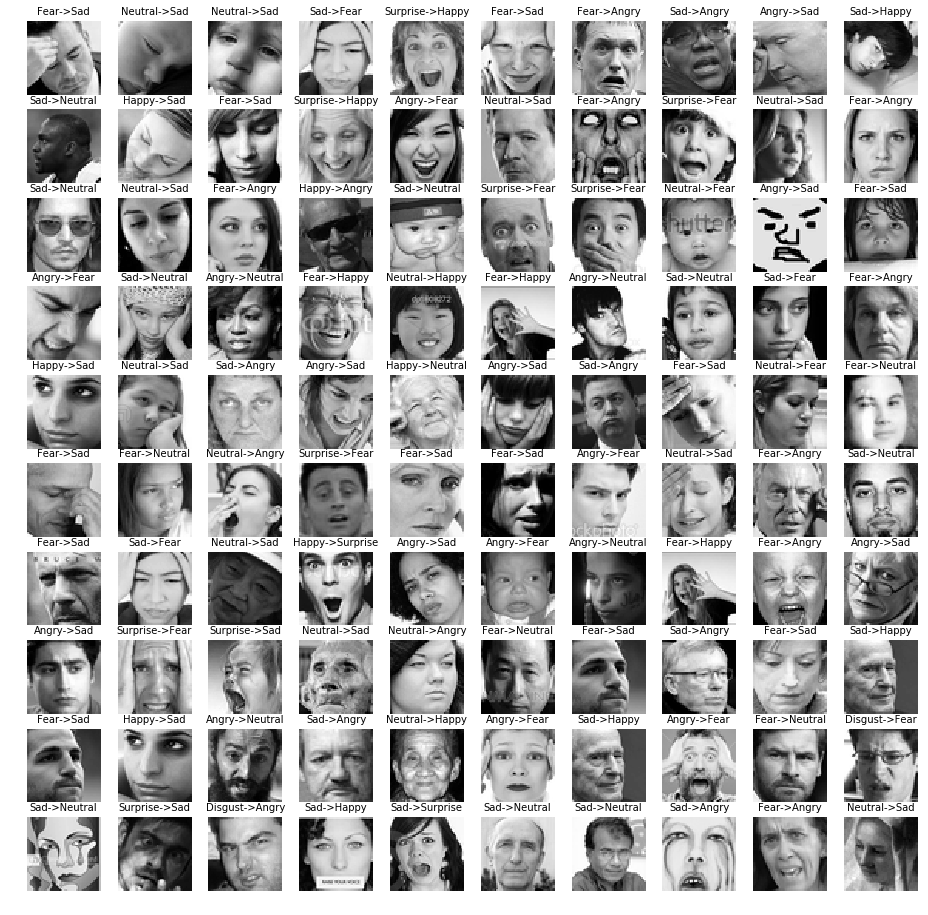

In [211]:
np.random.seed(1)

fig = plt.figure(figsize=(16, 16))

rows = 10
cols = 10

for i in range(1, rows * cols + 1):
    idx = np.random.randint(0, len(images))
    
    fig.add_subplot(rows, cols, i)
    image = np.array(images[idx], dtype=float)
    plt.imshow(image.reshape((48, 48)), cmap = 'gray')
    plt.title(str(misclassified.loc[idx, 'true']) + "->" + str(misclassified.loc[idx, 'pred']), 
              fontdict = {'fontsize': 10, 'color': "black"})
    plt.axis('off')
plt.show()

### Confusion matrices

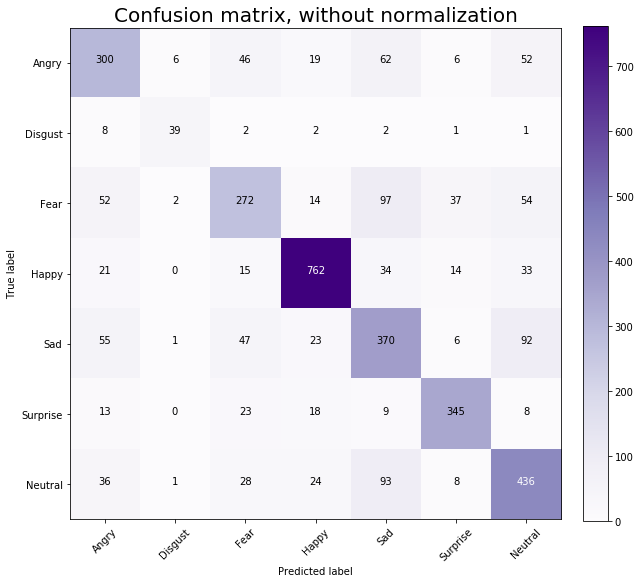

In [212]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)

plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

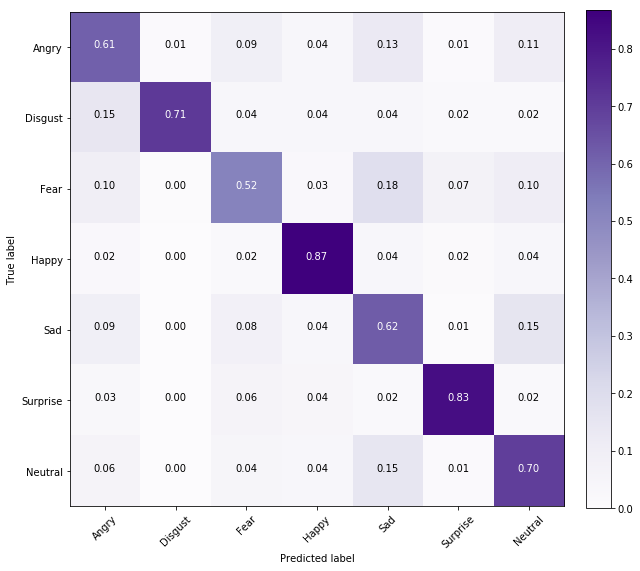

In [213]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')